In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_parquet("data/train_df.parquet")

In [3]:
train_df

,day,zid,customers_cnt_total,customers_cnt_long,customers_cnt_work,customers_cnt_loc,month,target,neighbors_list
0,4,4176,3776.354167,3097.958333,984.104167,1819.666667,4,1,"[122071, 61371, 174319, 178073, 63606, 49204, ..."
1,4,8814,2596.645833,2117.208333,391.479167,1808.729167,4,1,"[76984, 177459, 44588, 162228, 138843, 142788,..."
2,4,21765,4634.666667,4083.354167,541.250000,3745.520833,4,1,"[185718, 1535, 14551, 166886, 152565, 132135, ..."
3,4,37096,4526.750000,3748.625000,877.312500,3092.604167,4,1,"[149871, 4924, 92127, 143668, 111069, 31677, 6..."
4,4,43184,4035.375000,3357.541667,484.312500,2857.208333,4,1,"[140346, 38681, 97522, 44971, 92672, 8328, 648..."
...,...,...,...,...,...,...,...,...,...
21776,30,189604,4964.250000,3929.166667,782.479167,2980.000000,4,1,"[180175, 3450, 184227, 21825, 42074, 149187, 1..."
21777,30,189645,2720.937500,2394.958333,234.979167,2203.104167,4,1,"[6851, 12379, 126550, 112373, 68262, 126101, 8..."
21778,30,189974,2651.062500,2197.833333,340.479167,2146.125000,4,3,"[92377, 9970, 160396, 52584, 174906, 11987, 17..."
21779,30,190081,3016.354167,2577.500000,311.229167,2395.750000,4,1,"[122937, 159545, 123160, 57990, 38561, 16979, ..."


In [4]:
train_df = train_df.drop(train_df.loc[train_df.target > 10].index, axis=0)

In [5]:
features = ['customers_cnt_total', 'customers_cnt_long', 'customers_cnt_work', 'customers_cnt_loc']

In [6]:
for feat in features:
    train_df[feat + '_shifted1'] = train_df[['zid', feat]].groupby('zid').shift()
    train_df[feat + '_shifted2'] = train_df[['zid', feat]].groupby('zid').shift(2)
    train_df[feat + '_shifted3'] = train_df[['zid', feat]].groupby('zid').shift(3)

In [7]:
train_df['target_shifted1'] = train_df[['zid', 'target']].groupby('zid').shift()
train_df['target_shifted2'] = train_df[['zid', 'target']].groupby('zid').shift(2)
train_df['target_shifted3'] = train_df[['zid', 'target']].groupby('zid').shift(3)

In [8]:
shifted_features = [x for x in train_df.columns if 'shifted' in x]

In [9]:
train_df = train_df.fillna(0)

In [10]:
train_df['neighbors_list'][0]

array([122071,  61371, 174319, 178073,  63606,  49204,  14134,  91947])

In [11]:
X = train_df[['day'] + shifted_features + ['target']]

In [12]:
X_train = X.loc[X.day < 25]
X_test = X.loc[X.day >= 25]

In [13]:
estimator = LGBMRegressor()

In [14]:
shifted_features

['customers_cnt_total_shifted1',
 'customers_cnt_total_shifted2',
 'customers_cnt_total_shifted3',
 'customers_cnt_long_shifted1',
 'customers_cnt_long_shifted2',
 'customers_cnt_long_shifted3',
 'customers_cnt_work_shifted1',
 'customers_cnt_work_shifted2',
 'customers_cnt_work_shifted3',
 'customers_cnt_loc_shifted1',
 'customers_cnt_loc_shifted2',
 'customers_cnt_loc_shifted3',
 'target_shifted1',
 'target_shifted2',
 'target_shifted3']

In [15]:
estimator.fit(X_train[shifted_features].transform(np.log), np.log(X_train['target']))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
pred_train = estimator.predict(X_train[shifted_features].transform(np.log))
pred_test = estimator.predict(X_test[shifted_features].transform(np.log))

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
print(f"MAE TRAIN:{mean_absolute_error(X_train['target'], np.exp(pred_train))}")
print(f"MAE TEST:{mean_absolute_error(X_test['target'], np.exp(pred_test))}")
print(f"MSE TRAIN:{mean_squared_error(X_train['target'], np.exp(pred_train))}")
print(f"MSE TEST:{mean_squared_error(X_test['target'], np.exp(pred_test))}")

MAE TRAIN:0.4655397477710169
MAE TEST:0.6994219878989238
MSE TRAIN:0.5738174054484267
MSE TEST:1.120441018677441


In [19]:
X_train['preds'] = np.exp(pred_train)
X_test['preds'] = np.exp(pred_test)

/home/pburtovoy/.conda/envs/hackaton/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/pburtovoy/.conda/envs/hackaton/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
X_train[['target', 'preds']]

,target,preds
0,1,1.120041
1,1,1.120041
2,1,1.120041
3,1,1.120041
4,1,1.120041
...,...,...
13104,3,1.569148
13105,1,1.120041
13106,2,1.406358
13107,1,1.322865


In [21]:
from matplotlib import pyplot as plt
error = X_train['target'] -  X_train['preds']

Text(0.5, 1.0, 'Error')

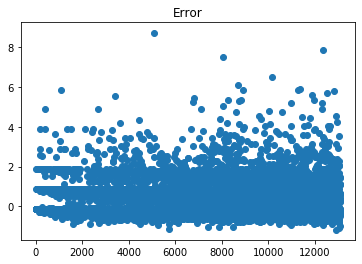

In [22]:
plt.scatter(np.arange(len(error)), error)
plt.title("Error")

Text(0.5, 1.0, 'Prediction Distribution')

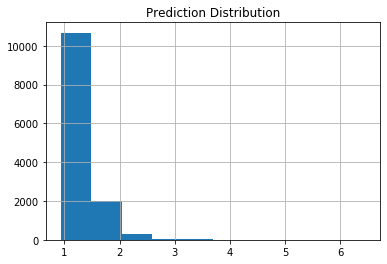

In [23]:
X_train.preds.hist()
plt.title("Prediction Distribution")

Text(0.5, 1.0, 'Target Distribution')

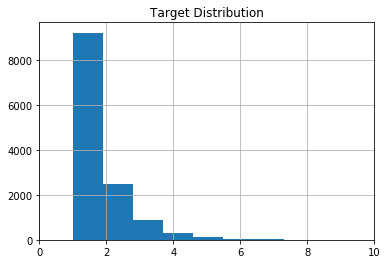

In [24]:
X_train.target.hist()
plt.xlim((0, 10))
plt.title("Target Distribution")

# Neighbors features

In [35]:
train_df['id_day'] = train_df['zid'].astype(str) + "_" + train_df['day'].astype(str)

In [39]:
train_df['n_neighbors'] = train_df.neighbors_list.apply(len)

In [41]:
drop_row = train_df.loc[train_df.n_neighbors == 6].index

In [42]:
train_df.drop(drop_row, axis=0, inplace=True)

In [43]:
for k in range(8):
    train_df['neighbor_'+str(k)] = [i[k] for i in train_df['neighbors_list']]
    train_df['neighbor_'+str(k)] = train_df['neighbor_'+str(k)].astype(str) + "_" + (train_df['day'].astype(int) - 1).astype(str)

In [44]:
def make_features(train_df, feature):
    gen_features = []
    for i in range(8):
        temp_df = train_df[[feature]].copy()
        temp_df['id'] = train_df['id_day'].copy()
        gen_features.append(feature+'_neighbor_'+str(i))
        train_df[feature+'_neighbor_'+str(i)] = train_df.merge(temp_df, how='left', left_on='neighbor_'+str(i), right_on='id')[feature+"_y"]
        train_df.fillna(0, inplace=True)
    train_df[feature+"_sum"] = train_df[gen_features].sum(axis=1)
    train_df[feature+"_mean"] = train_df[gen_features].mean(axis=1)
    train_df[feature+"_var"] = train_df[gen_features].var(axis=1)
    train_df.drop(gen_features, axis=1,inplace=True)
    return(train_df)

In [45]:
for feat in shifted_features:
    train_df = make_features(train_df, feat)

In [47]:
train_df.columns

Index(['day', 'zid', 'customers_cnt_total', 'customers_cnt_long',
       'customers_cnt_work', 'customers_cnt_loc', 'month', 'target',
       'neighbors_list', 'customers_cnt_total_shifted1',
       'customers_cnt_total_shifted2', 'customers_cnt_total_shifted3',
       'customers_cnt_long_shifted1', 'customers_cnt_long_shifted2',
       'customers_cnt_long_shifted3', 'customers_cnt_work_shifted1',
       'customers_cnt_work_shifted2', 'customers_cnt_work_shifted3',
       'customers_cnt_loc_shifted1', 'customers_cnt_loc_shifted2',
       'customers_cnt_loc_shifted3', 'target_shifted1', 'target_shifted2',
       'target_shifted3', 'id_day', 'n_neighbors', 'neighbor_0', 'neighbor_1',
       'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5', 'neighbor_6',
       'neighbor_7', 'customers_cnt_total_shifted1_sum',
       'customers_cnt_total_shifted1_mean', 'customers_cnt_total_shifted1_var',
       'customers_cnt_total_shifted2_sum', 'customers_cnt_total_shifted2_mean',
       'custome

In [48]:
new_features = [x for x in train_df.columns if 'shifted' in x]

In [50]:
X = train_df[['day'] + new_features + ['target']]

In [51]:
X_train = X.loc[X.day < 25]
X_test = X.loc[X.day >= 25]

In [168]:
estimator = LGBMRegressor(n_estimators=1, learning_rate=0.1, colsample_bytree=0.3, max_depth=1, reg_alpha=1, reg_lambda=1)

In [169]:
estimator.fit(X_train[new_features].transform(np.log), np.log(X_train['target']))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
              importance_type='split', learning_rate=0.1, max_depth=1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=1, reg_lambda=1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [170]:
pred_train = estimator.predict(X_train[new_features].transform(np.log))
pred_test = estimator.predict(X_test[new_features].transform(np.log))

In [171]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [172]:
print(f"MAE TRAIN:{mean_absolute_error(X_train['target'], np.exp(pred_train))}")
print(f"MAE TEST:{mean_absolute_error(X_test['target'], np.exp(pred_test))}")
print(f"MSE TRAIN:{mean_squared_error(X_train['target'], np.exp(pred_train))}")
print(f"MSE TEST:{mean_squared_error(X_test['target'], np.exp(pred_test))}")

MAE TRAIN:0.5849458584615649
MAE TEST:0.7379727711566644
MSE TRAIN:0.8293784908037275
MSE TEST:1.2981026511069882


In [101]:
X_train['preds'] = np.exp(pred_train)
X_test['preds'] = np.exp(pred_test)

/home/pburtovoy/.conda/envs/hackaton/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/pburtovoy/.conda/envs/hackaton/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
from matplotlib import pyplot as plt
error = X_train['target'] -  X_train['preds']

Text(0.5, 1.0, 'Error')

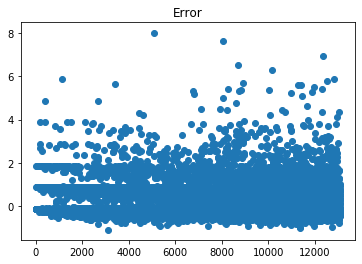

In [103]:
plt.scatter(np.arange(len(error)), error)
plt.title("Error")

Text(0.5, 1.0, 'Prediction Distribution')

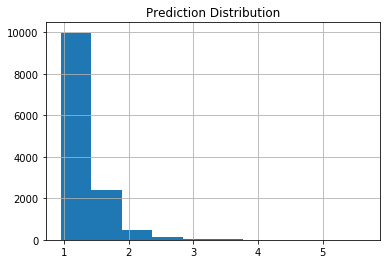

In [104]:
X_train.preds.hist()
plt.title("Prediction Distribution")

Text(0.5, 1.0, 'Target Distribution')

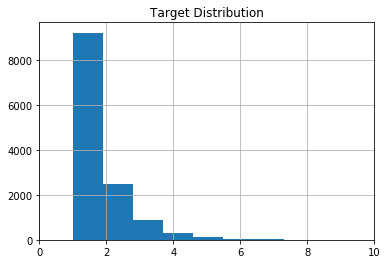

In [105]:
X_train.target.hist()
plt.xlim((0, 10))
plt.title("Target Distribution")

In [109]:
feat_imp = pd.DataFrame(index=estimator.feature_name_, data=estimator.feature_importances_, columns=['importance'])
feat_imp = feat_imp.sort_values('importance', ascending=False)

In [110]:
import seaborn as sns

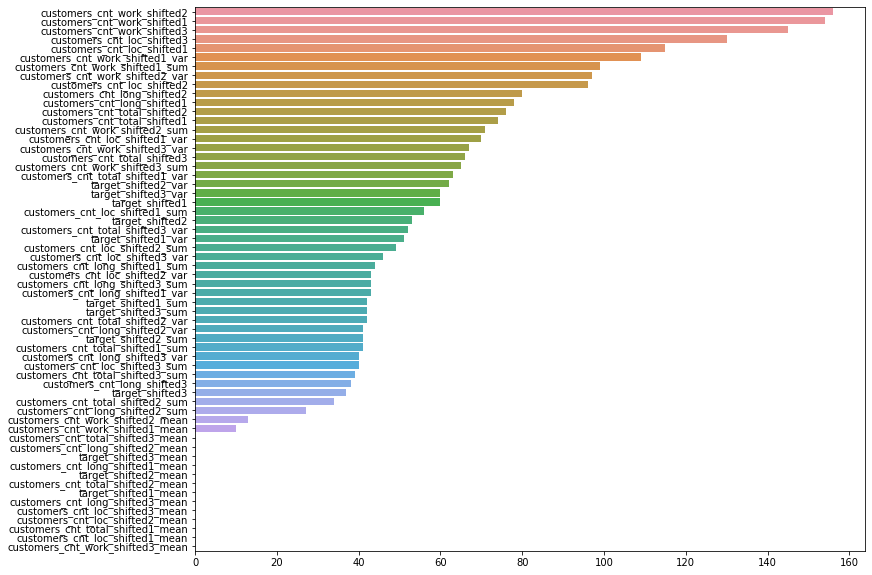

In [175]:
fig = plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp.values[:, 0], y=feat_imp.index)